# Analysis of human RAS saturation mutagenesis data

In this tutorial, we compare computational predictions from Rhapsody, PolyPhen-2 and EVmutation against experimental functional assessments of human RAS mutants presented in:
[Bandaru P et al, *Deconstruction of the Ras switching cycle through saturation mutagenesis*, Elife (2017)](https://elifesciences.org/articles/27810)

All results and figures presented here are described and interpreted in the Rhapsody paper and all data needed to fully reproduce them are provided.

In [1]:
import sys, os, pickle, csv, glob
import numpy as np

In [2]:
import prody

In [3]:
# If needed, insert here local path to Rhapsody folder with the command:
# sys.path.insert(0, '/LOCAL_PATH/rhapsody/')
import rhapsody as rhaps

## Re-training of unbiased classifier

A few RAS mutations are found in the Integrated Dataset used for training. In order to get completely unbiased predictions, we will retrain a classifier by excluding those variants from the training dataset.

**NB:** The Uniprot name for gene HRAS is `P01112`.

In [4]:
# import the numpy structured array containing precomputed features
ID = np.load('../00-Training_Dataset/data/precomputed_features-ID.npy')
ID.dtype

dtype([('SAV_coords', '<U50'), ('Uniprot2PDB', '<U100'), ('PDB_length', '<i2'), ('true_label', '<i2'), ('ANM_MSF-chain', '<f4'), ('ANM_MSF-reduced', '<f4'), ('ANM_MSF-sliced', '<f4'), ('ANM_effectiveness-chain', '<f4'), ('ANM_effectiveness-reduced', '<f4'), ('ANM_effectiveness-sliced', '<f4'), ('ANM_sensitivity-chain', '<f4'), ('ANM_sensitivity-reduced', '<f4'), ('ANM_sensitivity-sliced', '<f4'), ('BLOSUM', '<f4'), ('Delta_PSIC', '<f4'), ('Delta_SASA', '<f4'), ('EVmut-DeltaE_epist', '<f4'), ('EVmut-DeltaE_indep', '<f4'), ('EVmut-mut_aa_freq', '<f4'), ('EVmut-wt_aa_cons', '<f4'), ('GNM_MSF-chain', '<f4'), ('GNM_MSF-reduced', '<f4'), ('GNM_MSF-sliced', '<f4'), ('GNM_effectiveness-chain', '<f4'), ('GNM_effectiveness-reduced', '<f4'), ('GNM_effectiveness-sliced', '<f4'), ('GNM_sensitivity-chain', '<f4'), ('GNM_sensitivity-reduced', '<f4'), ('GNM_sensitivity-sliced', '<f4'), ('SASA', '<f4'), ('SASA_in_complex', '<f4'), ('entropy', '<f4'), ('ranked_MI', '<f4'), ('stiffness-chain', '<f4'), ('

In [5]:
# discard variants with ambiguous clinical interpretations
ID = ID[ID['true_label'] != -1]

In [6]:
ID_del = ID[ID['true_label'] == 1]  # deleterious SAVs
ID_neu = ID[ID['true_label'] == 0]  # neutral SAVs

known_del_SAVs = [SAV['SAV_coords'] for SAV in ID_del if SAV['SAV_coords'].startswith('P01112')]
known_neu_SAVs = [SAV['SAV_coords'] for SAV in ID_neu if SAV['SAV_coords'].startswith('P01112')]

print(f'{len(known_del_SAVs)} known deleterious RAS SAVs:')
print(known_del_SAVs)
print(f'\n{len(known_neu_SAVs)} known neutral RAS SAVs:')
print(known_neu_SAVs)

17 known deleterious RAS SAVs:
['P01112 117 K R', 'P01112 12 G A', 'P01112 12 G C', 'P01112 12 G D', 'P01112 12 G E', 'P01112 12 G S', 'P01112 12 G V', 'P01112 13 G C', 'P01112 13 G D', 'P01112 13 G R', 'P01112 146 A T', 'P01112 146 A V', 'P01112 22 Q K', 'P01112 58 T I', 'P01112 61 Q K', 'P01112 61 Q L', 'P01112 63 E K']

0 known neutral RAS SAVs:
[]


Let's exclude these variants from the dataset. 

In [7]:
ID_subset = ID[ [not SAV.startswith('P01112') for SAV in ID['SAV_coords']] ]
len(ID_subset)

87709

We will also only consider variants with at least 1 ClinVar review star (when available) and with an associated PDB structure larger than 150 residues, two restrictions that we found to improve the classifier accuracy (see `RF_optimization` tutorial).

In [8]:
ID_SAVs_info = np.load('../00-Training_Dataset/data/Integrated_Dataset-SAVs.npy')
zero_star_SAVs = ID_SAVs_info[ ID_SAVs_info['ClinVar_review_star'] == 0 ]['SAV_coords']

ID_subset = ID_subset[ [SAV not in zero_star_SAVs for SAV in ID_subset['SAV_coords']] ]
len(ID_subset)

80200

In [9]:
ID_subset = ID_subset[ID_subset['PDB_length'] >= 150]
len(ID_subset)

20346

We use this subset of the Integrated Dataset to train unbiased versions of the Rhapsody classifiers:

In [10]:
featsets = {
    # full Rhapsody classifier, which includes conservation features, structural/dynamical
    # features, and Pfam-based features
    'full_clsf': [ 'wt_PSIC', 'Delta_PSIC', 'SASA', 
                   'ANM_MSF-chain', 'ANM_effectiveness-chain', 'ANM_sensitivity-chain',
                   'stiffness-chain', 'entropy', 'ranked_MI', 'BLOSUM' ],
    # reduced classifier, which does not include Pfam-based features
    'redx_clsf': [ 'wt_PSIC', 'Delta_PSIC', 'SASA', 
                   'ANM_MSF-chain', 'ANM_effectiveness-chain', 'ANM_sensitivity-chain',
                   'stiffness-chain', 'BLOSUM' ]
}

In [11]:
if os.path.isdir('results'):
    print('Precomputed classifiers found.')
else:
    os.mkdir('results/')
    
    prody.LOGGER.start('results/RF_training.log')
    summaries = {}
    
    for clsf_version, featset in featsets.items():
        folder = f'results/{clsf_version}'
        os.mkdir(folder)
        
        # training of the Random Forest classifier on the given set of features
        f = ['SAV_coords', 'true_label'] + featset
        output_dict = rhaps.trainRFclassifier(ID_subset[f])
        summaries[clsf_version] = output_dict['CV summary']
        
        for file in glob.glob('*png') + ['trained_classifier.pkl',]:
            os.rename(file, os.path.join(folder, file))
            
        prody.LOGGER.info('')
                    
    # store training summary into pickle
    pickle.dump(summaries, open('results/summaries.pkl', 'wb'))

    prody.LOGGER.close('results/RF_training.log')

Precomputed classifiers found.


## Rhapsody predictions
We perform a complete scanning of all amino acid variants (*in silico* saturation mutagenesis).

**NB:** PolyPhen-2 predictions are precomputed and saved in `data/pph2`

In [12]:
if os.path.isdir('results/predictions'):
    rh = pickle.load(open('results/predictions/rhapsody-pickle.pkl', 'rb'))
    print('Precomputed predictions imported.')
else:
    os.mkdir('results/predictions')
    # run rhapsody
    rh = rhaps.rhapsody('data/pph2/pph2-full.txt', 'results/full_clsf/trained_classifier.pkl',
                        aux_classifier='results/redx_clsf/trained_classifier.pkl', input_type='PP2')
    # store files
    for f in glob.glob('rhapsody-*.*'):
        os.rename(f, os.path.join('results/predictions', f))

Precomputed predictions imported.


### Active *vs* inactive state
Rhapsody automatically maps most variants onto PDB structure `4Q21`, which is the GDP-complexed **inactive** conformation:

In [13]:
PDBIDs = [l['PDB SAV coords'][:4] for l in rh.Uniprot2PDBmap if l['PDB size']!=0]
for PDBID in set(PDBIDs):
    print(PDBID, 'n.SAVs:', PDBIDs.count(PDBID))

1AA9 n.SAVs: 57
4Q21 n.SAVs: 3192


We can force Rhapsody to use, for instance, the **active** (GTP-bound) structure `6Q21` instead:

In [14]:
if os.path.isdir('results/predictions_active'):
    rh_active = pickle.load(open('results/predictions_active/rhapsody-pickle.pkl', 'rb'))
    print('Precomputed predictions imported.')    
else:
    os.mkdir('results/predictions_active')
    # run rhapsody
    rh_active = rhaps.rhapsody('data/pph2/pph2-full.txt', 'results/full_clsf/trained_classifier.pkl',
                               aux_classifier='results/redx_clsf/trained_classifier.pkl', input_type='PP2', 
                               custom_PDB='6Q21')
    # store files
    for f in glob.glob('rhapsody-*.*'):
        os.rename(f, os.path.join('results/predictions_active', f))

Precomputed predictions imported.


## Analysis of predictions: active *vs* inactive state

In [15]:
import matplotlib.pyplot as plt
from scipy.stats.stats import spearmanr

In [16]:
if not os.path.isdir('figures'):
    os.mkdir('figures')

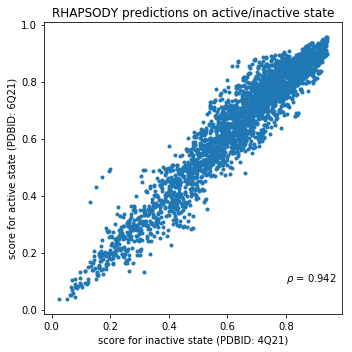

In [17]:
# import random forest scores
score_inactive = rh.mixPreds['score']
score_active   = rh_active.mixPreds['score']

fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(score_inactive, score_active, marker='.')
ax.set_xlabel('score for inactive state (PDBID: 4Q21)')
ax.set_ylabel('score for active state (PDBID: 6Q21)')

# compute Spearman's correlation coefficient
sel = np.logical_and(~np.isnan(score_inactive), ~np.isnan(score_active))
rho = spearmanr(score_inactive[sel], score_active[sel])[0]

s = r'$\rho$'
ax.set_title('RHAPSODY predictions on active/inactive state')
ax.text(0.8, 0.1, f'{s} = {rho:5.3f}')

fig.tight_layout()
plt.savefig(f'figures/active_vs_inactive_correlation.png', dpi=300)

In general, predictions based on inactive *vs* active conformations are very similar. We can plot the *residue-averaged* prediction profiles on the respective structures to better highlight differences.

In [18]:
avg_prob = {}

# import "mixed" predicted pathogenicity probabilities 
# (i.e. obtained from either the full classifier or the 
# reduced one, when the former is not applicable)

# inactive conformation 
_p = rh.mixPreds['path. probability']
_m = _p.reshape((-1, 19)).T
avg_prob['inactive'] = np.nanmean(_m, axis=0)
# active conformation
_p = rh_active.mixPreds['path. probability']
_m = _p.reshape((-1, 19)).T
avg_prob['active'] = np.nanmean(_m, axis=0)
# difference between inactive and active profiles
avg_prob['difference'] = avg_prob['active'] - avg_prob['inactive']

# residue numbers
resids = rh.SAVcoords['pos'].reshape((-1, 19)).T[0]

/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


In [19]:
import prody

# import PDB structures
pdbs = {}
pdbs['inactive']   = prody.parsePDB('4q21', chain='A').select('protein and resid 2 to 166')
pdbs['active']     = prody.parsePDB('6q21', chain='A').select('protein and resid 2 to 166')
pdbs['difference'] = pdbs['active']

@> PDB file is found in the local folder (/home/lponzoni/.../4q21.pdb.gz).
@> 1447 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> PDB file is found in the local folder (/home/lponzoni/.../6q21.pdb.gz).
@> 1484 atoms and 1 coordinate set(s) were parsed in 0.03s.


In [20]:
for case in ['inactive', 'active', 'difference']:
    pdb = pdbs[case]
    # replace the B-factor column in chain A with predictions
    PDBresids = pdb.getResnums()
    new_betas = np.zeros_like(PDBresids, dtype=float)
    for resid, prob in zip(resids, avg_prob[case]):
        if np.isnan(prob):
            prob = 0
        new_betas[PDBresids==int(resid)] = prob
    # write modified PDB
    pdb.setBetas(new_betas)
    f = prody.writePDB(f'figures/mapped_pdb-{case}', pdb)

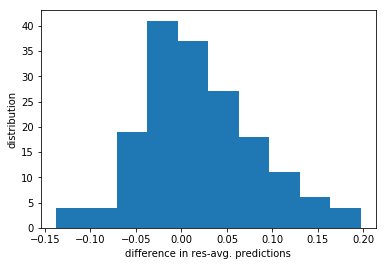

In [21]:
# plot the distribution of difference values
diff = avg_prob['difference']
plt.hist(diff[~np.isnan(diff)])
plt.ylabel('distribution')
plt.xlabel('difference in res-avg. predictions');

## Comparison with experimental results from Bandaru et al.

In [22]:
# import data from file
data = {}

for f in glob.glob('data/*csv'):
    fname = os.path.basename(f, )
    case = fname.replace('.csv', '')
    with open(f, 'r') as _f:
        reader = csv.reader(_f)
        data[case] = list(reader)
        
exp_sequence = ''.join(data['attenuated_RAS'][1])

**NB:** The sequence used in the experiments is a substring of the Uniprot sequence:

In [23]:
acc = 'P01112'
sequence = prody.queryUniprot(acc)['sequence   0'].replace('\n', '')

In [24]:
print('Uniprot sequence length:', len(sequence))
print('Exp. sequence length:   ', len(exp_sequence))

Uniprot sequence length: 189
Exp. sequence length:    165


In [25]:
exp_sequence == sequence[1: len(exp_sequence)+1]

True

In [26]:
# convert data to dictionary
tables = {}

for case, d in data.items():
    resids = d[0][1:]
    wt_aas = d[1][1:]
    table = {}
    for line in d[2:]:
        mut_aa = line[0]
        for i, x in enumerate(line[1:]):
            resid = int(resids[i])
            wt_aa = wt_aas[i]
            table[f'P01112 {resid} {wt_aa} {mut_aa}'] = float(x)
    tables[case] = table

In [27]:
# the dictionary contains data from 4 different experimental setups
tables.keys()

dict_keys(['regulated_RAS', 'unregulated_RAS', 'attenuated_RAS', 'G12V_RAS'])

In [28]:
# put exp. data in array form and in the same order as Rhapsody predictions
SAV_coords = rh.SAVcoords['text']

exp_scores = {}
for case, table in tables.items():
    a = np.zeros(len(SAV_coords))
    a[:] = np.nan
    for i, SAV in enumerate(SAV_coords):
        if SAV in table:
            a[i] = table[SAV]
    exp_scores[case] = a

# compute residue-averaged functional effects
avg_exp_scores = {}
for case, exp_score in exp_scores.items():
    avg_exp_scores[case] = np.nanmean(exp_score.reshape((-1, 19)), axis=1)

/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


In [29]:
# import computational scores
rhaps_score_inac = rh.mixPreds['score']
rhaps_score_actv = rh_active.mixPreds['score']
PP2_probs = np.array([float(x) for x in rh.PP2output['pph2_prob']])
EVmut_score = - np.array([float(x) for x in rh.calcEVmutationFeats()['EVmut-DeltaE_epist']])

methods = ['Rhapsody (inactive state)', 'Rhapsody (active state)', 'EVmutation', 'PolyPhen-2']

comput_scores = {
  'Rhapsody (inactive state)': rhaps_score_inac, 
  'Rhapsody (active state)' :  rhaps_score_actv, 
  'EVmutation' :               EVmut_score, 
  'PolyPhen-2' :               PP2_probs
}

# compute residue-averaged computational scores
avg_comput_scores = {}
for method, score in comput_scores.items():
    avg_comput_scores[method] = np.nanmean(score.reshape((-1, 19)), axis=1)

@> Recovering EVmutation data...
@> EVmutation scores recovered in 6.6s.
/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


### Spearman correlation

In the following, we compute and plot the correlation between experimental measurements and computational predictions.

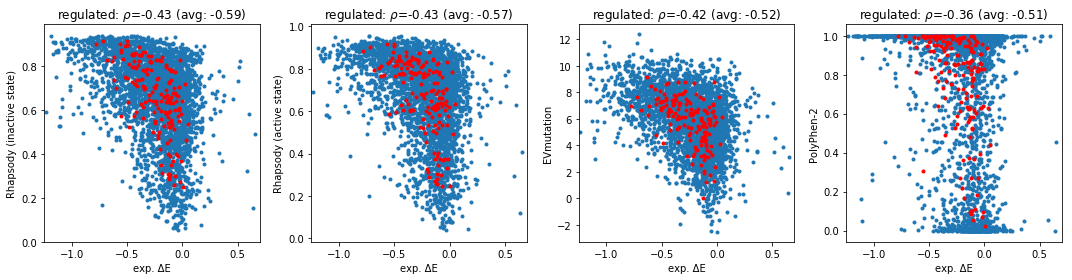

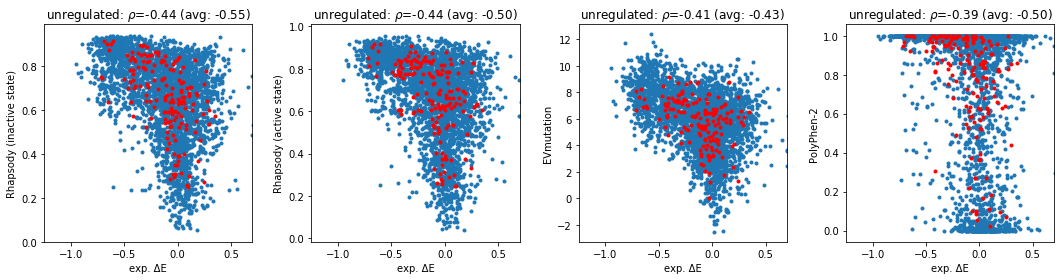

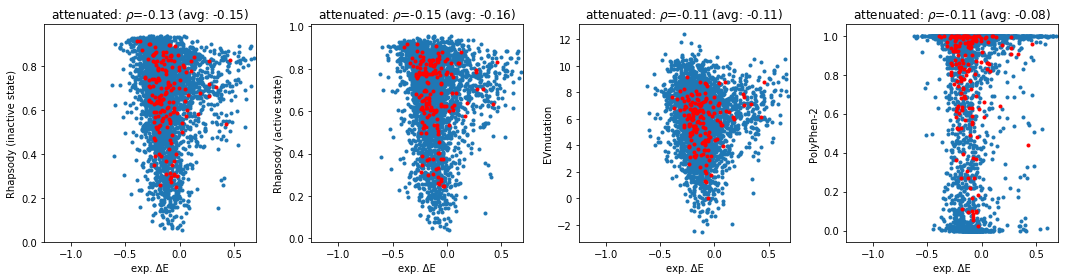

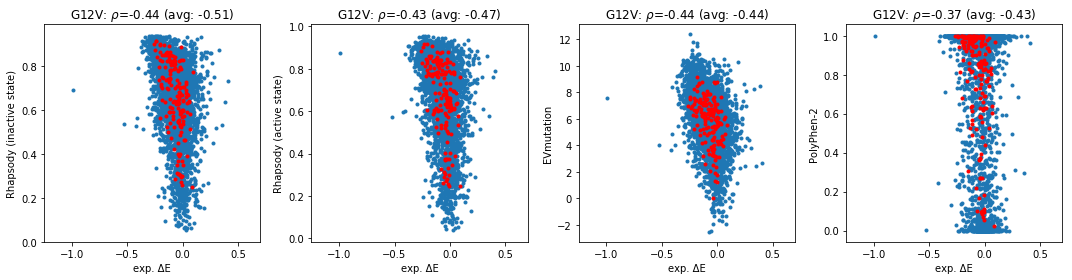

In [30]:
for case in exp_scores:
    exp_score     = exp_scores[case]
    avg_exp_score = avg_exp_scores[case]
    
    fig, axes = plt.subplots(1, 4, figsize=(15,4))
    
    for i, ax in enumerate(axes):
        method = methods[i]
        # individual fitness scores
        cs = comput_scores[method]
        ax.scatter(exp_score, cs, marker='.')
        sel = np.logical_and(~np.isnan(exp_score), ~np.isnan(cs))
        rho = spearmanr(exp_score[sel], cs[sel])[0]
        # residue-averaged fitness scores
        acs = avg_comput_scores[method]
        ax.scatter(avg_exp_score, acs, marker='.', c='r')
        sel = np.logical_and(~np.isnan(avg_exp_score), ~np.isnan(acs))
        rho_av = spearmanr(avg_exp_score[sel], acs[sel])[0]
        # print labels
        ax.set_ylabel(method)
        s = r'$\rho$'
        ax.set_title(f'{case[:-4]}: {s}={rho:5.2f} (avg: {rho_av:5.2f})')
        ax.set_xlim((-1.25, 0.7))
        ax.set_xlabel('exp. ΔE')

    fig.tight_layout()
    plt.savefig(f'figures/correlation-{case}.png', dpi=300)

Since the goal of Rhapsody is to identify mutations that impair the normal activity and interactions of proteins, specifically by taking into account changes to their internal structural dynamics, we can focus on the "regulated" case (its "wild-type" context) among those presented in the paper.
From the plots in the first line, we see that Rhapsody (computed on both inactive and active states) performs in general better than both EVmutation and PolyPhen-2. 

### ROCs, Precision-Recall curves and other metrics

We can also obtain a binary classification from the distribution of functional effects by setting a cutoff according to what is considered a "significant loss of function". We will choose the median as cutoff. This allows us to compute ROC and Precision-Recall curves and compare performances based on different metrics.

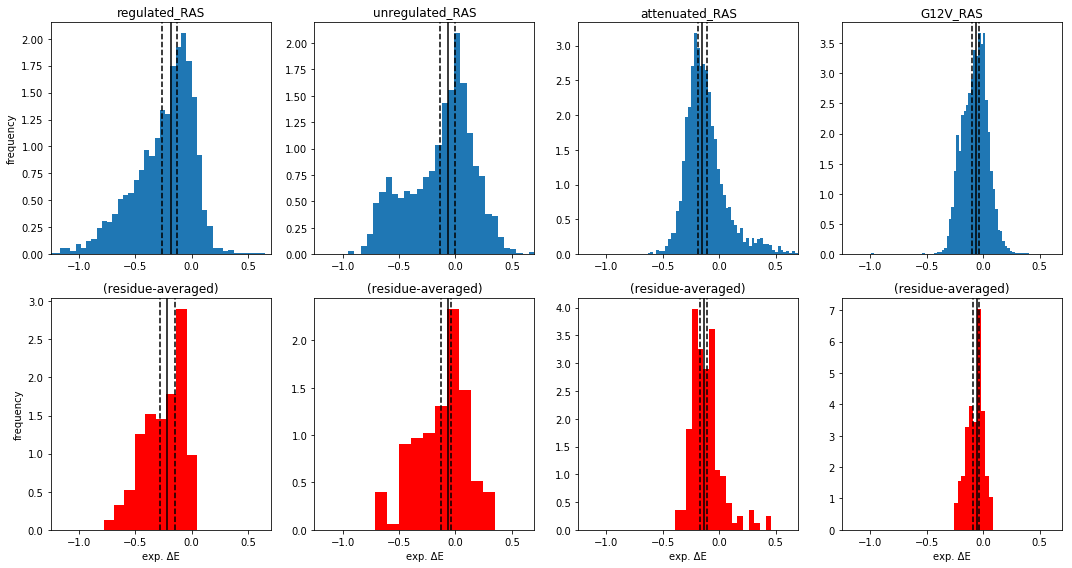

In [31]:
cutoff_qs = [40, 50, 60]
cutoff_qs.sort()

cutoffs = {}
avg_cutoffs = {}

fig, axes = plt.subplots(2, 4, figsize=(15,8))

for i, case in enumerate(exp_scores):
    exp_score = exp_scores[case]
    exp_score = exp_score[~np.isnan(exp_score)]
    avg_exp_score = avg_exp_scores[case]
    avg_exp_score = avg_exp_score[~np.isnan(avg_exp_score)]
    
    # cutoff definitions
    cutoffs[case]     = {q: np.nanpercentile(exp_score, q) for q in cutoff_qs}
    avg_cutoffs[case] = {q: np.nanpercentile(avg_exp_score, q) for q in cutoff_qs}
    
    ax1 = axes[0, i]
    ax2 = axes[1, i]
    
    ax1.hist(exp_score, density=True, bins='auto')
    ax2.hist(avg_exp_score, density=True, bins='auto', color='red')
    for q in cutoff_qs:
        cutoff     = cutoffs[case][q]
        avg_cutoff = avg_cutoffs[case][q]
        if q == cutoff_qs[1]:
            ax1.axvline(cutoff, color='k') 
            ax2.axvline(avg_cutoff, color='k') 
        else:
            ax1.axvline(cutoff, color='k', ls='--') 
            ax2.axvline(avg_cutoff, color='k', ls='--') 
    
    ax1.set_title(case)
    ax2.set_title('(residue-averaged)')
    ax1.set_xlim((-1.25, 0.7))
    ax2.set_xlim((-1.25, 0.7))
    ax2.set_xlabel('exp. ΔE')
    
axes[0,0].set_ylabel('frequency')
axes[1,0].set_ylabel('frequency')
    
fig.tight_layout()
fig.savefig(f'figures/histograms-cutoff.png', dpi=300)

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import f1_score, matthews_corrcoef

metrics = {}

for case in exp_scores:
    
    metrics[case] = {}
    
    # experimental measurements (fitness effects)
    exp_score     = exp_scores[case]
    avg_exp_score = avg_exp_scores[case]

    # loop over computational methods 
    for method in methods:
                      
        # individual and residue-averaged computational predictions fitness effects
        comput_score = comput_scores[method]
        avg_comput_score = avg_comput_scores[method]
        
        # discard NaN values
        sel = np.logical_and(~np.isnan(exp_score), ~np.isnan(comput_score))
        avg_sel = np.logical_and(~np.isnan(avg_exp_score), ~np.isnan(avg_comput_score))

        m = {}
        
        # loop over cutoffs for experimental values
        for q in cutoff_qs:
            cutoff     = cutoffs[case][q]
            avg_cutoff = avg_cutoffs[case][q]
            
            m[q] = {}
            
            # binary classification and computational score for individual measurements
            exp_class = np.where(exp_score[sel] < cutoff, 1, 0)
            cs = comput_score[sel]
            # curves and metrics
            fpr, tpr, _   = roc_curve(exp_class, cs)
            prc, rec, _   = precision_recall_curve(exp_class, cs)
            m[q]['ROC']   = (fpr, tpr)
            m[q]['PRC']   = (prc, rec)
            m[q]['AUROC'] = roc_auc_score(exp_class, cs)
            m[q]['AUPRC'] = average_precision_score(exp_class, cs)

            # binary classification for residue-averaged measurements
            exp_class = np.where(avg_exp_score[avg_sel] < avg_cutoff, 1, 0)
            cs = avg_comput_score[avg_sel]
            # curves and metrics
            fpr, tpr, _   = roc_curve(exp_class, cs)
            prc, rec, _   = precision_recall_curve(exp_class, cs)
            m[q]['avg_ROC']   = (fpr, tpr)
            m[q]['avg_PRC']   = (prc, rec)
            m[q]['avg_AUROC'] = roc_auc_score(exp_class, cs)
            m[q]['avg_AUPRC'] = average_precision_score(exp_class, cs)

        metrics[case][method] = m

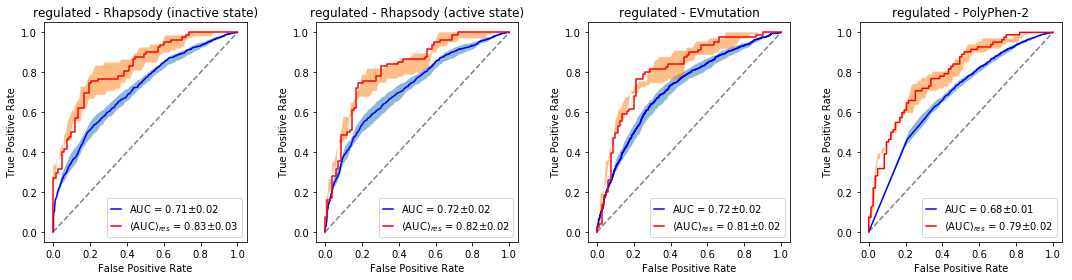

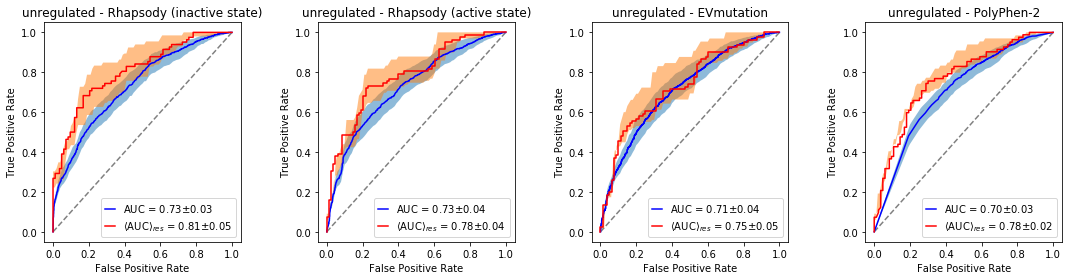

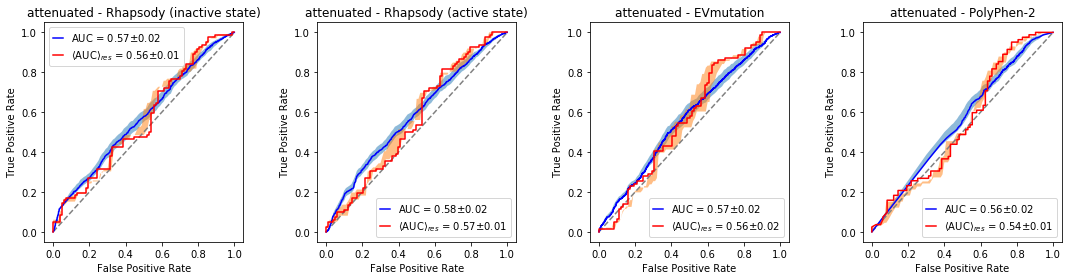

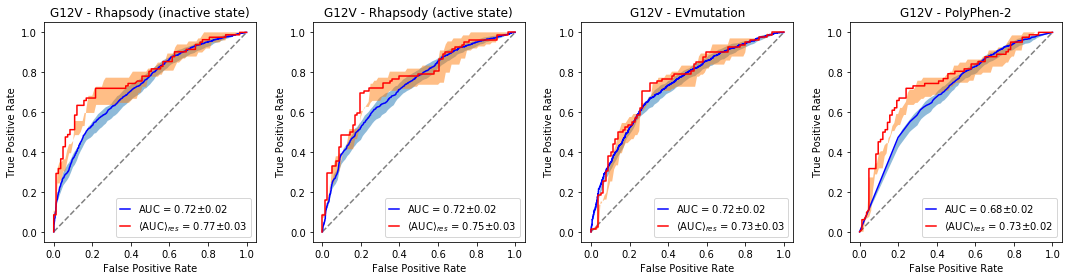

In [33]:
for case in exp_scores:

    fig, axes = plt.subplots(1, 4, figsize=(15,4))
    
    for i, ax in enumerate(axes):
        method = methods[i]
        
        m = metrics[case][method]
        q0, q1, q2 = cutoff_qs
        
        # random ROC
        ax.plot([0,1], [0,1], '--', color='gray')
        
        # plot for individual fitness effects
        aucs = [m[q]['AUROC'] for q in m.keys()]
        l = r'AUC = {:4.2f}$\pm${:4.2f}'.format(np.mean(aucs), np.std(aucs))
        ax.plot(m[q1]['ROC'][0], m[q1]['ROC'][1], 'b-', label=l)
        x_dense = np.arange(0,1,.01) 
        ax.fill_between(x_dense, np.interp(x_dense, m[q0]['ROC'][0], m[q0]['ROC'][1]), 
                                 np.interp(x_dense, m[q2]['ROC'][0], m[q2]['ROC'][1]), alpha=.5)

        # plot for residue-averaged fitness effects
        aucs = [m[q]['avg_AUROC'] for q in m.keys()]
        l = r'$\langle$AUC$\rangle _{res}$ = ' 
        l += r'{:4.2f}$\pm${:4.2f}'.format(np.mean(aucs), np.std(aucs)) 
        ax.plot(m[q1]['avg_ROC'][0], m[q1]['avg_ROC'][1], 'r-', label=l)
        x_dense = np.arange(0,1,.01) 
        ax.fill_between(x_dense, np.interp(x_dense, m[q0]['avg_ROC'][0], m[q0]['avg_ROC'][1]), 
                                 np.interp(x_dense, m[q2]['avg_ROC'][0], m[q2]['avg_ROC'][1]), alpha=.5)
        
        # set labels
        ax.set_title(f'{case[:-4]} - {method}')   
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(handlelength=1)

    fig.tight_layout()
    fig.savefig(f'figures/ROC-{case}.png', dpi=300)

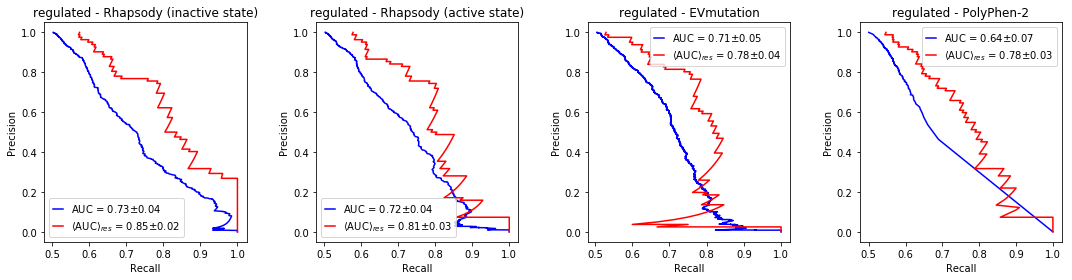

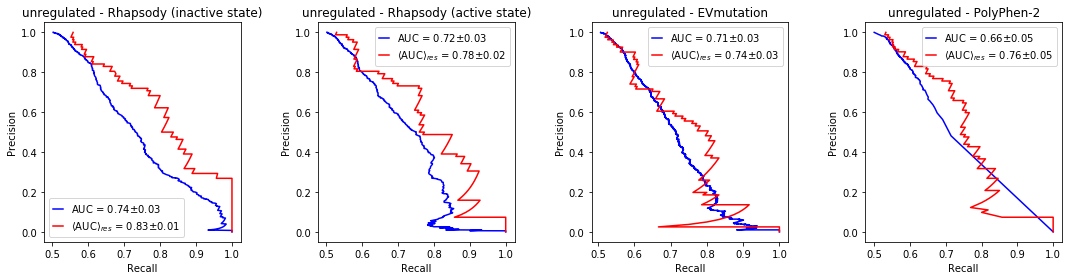

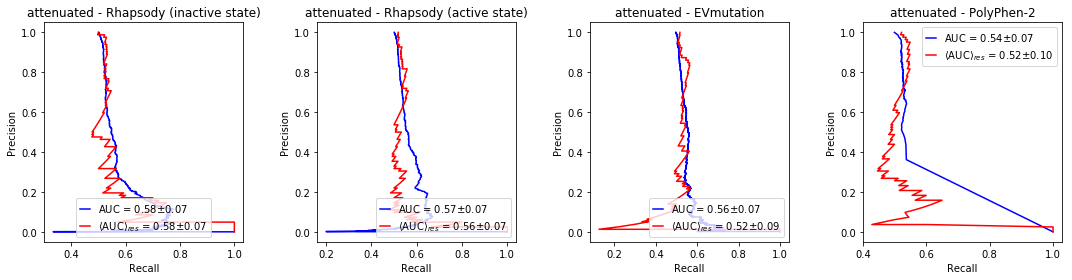

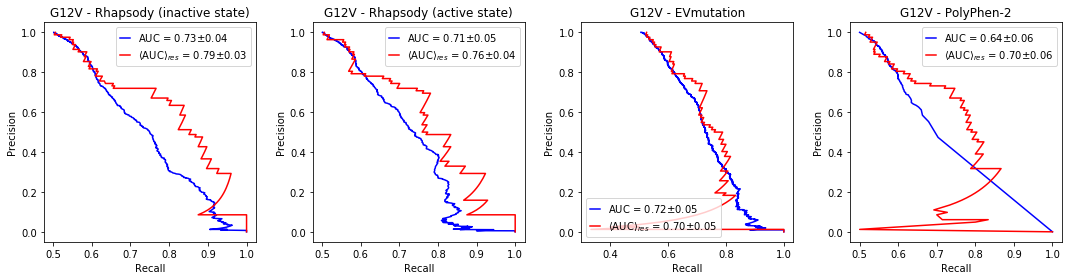

In [34]:
for case in exp_scores:

    fig, axes = plt.subplots(1, 4, figsize=(15,4))
    
    for i, ax in enumerate(axes):
        method = methods[i]
        
        m = metrics[case][method]
        q0, q1, q2 = cutoff_qs
        
        # plot for individual fitness effects
        aucs = [m[q]['AUPRC'] for q in cutoff_qs]
        l = r'AUC = {:4.2f}$\pm${:4.2f}'.format(np.mean(aucs), np.std(aucs))
        ax.plot(m[q1]['PRC'][0], m[q1]['PRC'][1], 'b-', label=l)

        # plot for residue-averaged fitness effects
        aucs = [m[q]['avg_AUPRC'] for q in cutoff_qs]
        l = r'$\langle$AUC$\rangle _{res}$ = ' 
        l += r'{:4.2f}$\pm${:4.2f}'.format(np.mean(aucs), np.std(aucs)) 
        ax.plot(m[q1]['avg_PRC'][0], m[q1]['avg_PRC'][1], 'r-', label=l)
        
        # set labels
        ax.set_title(f'{case[:-4]} - {method}')   
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(handlelength=1)

    fig.tight_layout()
    fig.savefig(f'figures/PRC-{case}.png', dpi=300)

In the following, we apply an alternative definition of "deleterious" variants, that include not only loss-of-function mutations, but also gain-of-function mutations. We can do that by considering as "positive cases" those whose difference in fitness with respect to wild-type is greater than a certain threshold, in both directions.

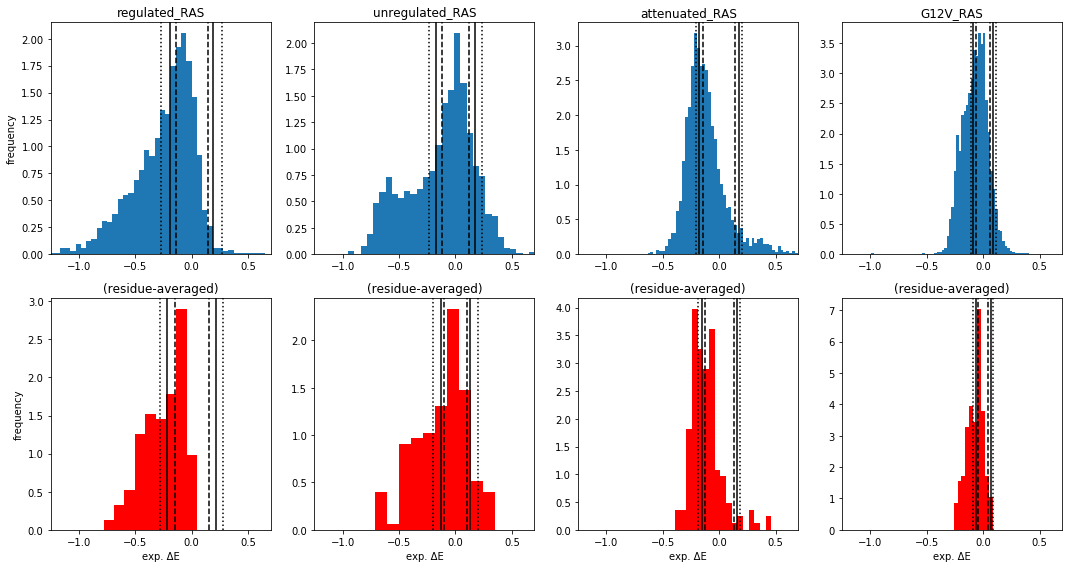

In [35]:
threshold_qs = [40, 50, 60]
threshold_qs.sort()

thresholds = {}
avg_thresholds = {}


fig, axes = plt.subplots(2, 4, figsize=(15,8))

for i, case in enumerate(exp_scores):
    exp_score = exp_scores[case]
    exp_score = exp_score[~np.isnan(exp_score)]
    avg_exp_score = avg_exp_scores[case]
    avg_exp_score = avg_exp_score[~np.isnan(avg_exp_score)]
    
    # threshold definitions
    thresholds[case]     = {q: np.nanpercentile(abs(exp_score), q) for q in cutoff_qs}
    avg_thresholds[case] = {q: np.nanpercentile(abs(avg_exp_score), q) for q in cutoff_qs}
    
    ax1 = axes[0, i]
    ax2 = axes[1, i]
    
    ax1.hist(exp_score, density=True, bins='auto')
    ax2.hist(avg_exp_score, density=True, bins='auto', color='red')

    for q, ls in zip(threshold_qs, ['--', '-', ':']):
        threshold     = thresholds[case][q]
        avg_threshold = avg_thresholds[case][q]
        ax1.axvline( threshold, color='k', ls=ls) 
        ax1.axvline(-threshold, color='k', ls=ls) 
        ax2.axvline( avg_threshold, color='k', ls=ls) 
        ax2.axvline(-avg_threshold, color='k', ls=ls) 
    
    ax1.set_title(case)
    ax2.set_title('(residue-averaged)')
    ax1.set_xlim((-1.25, 0.7))
    ax2.set_xlim((-1.25, 0.7))
    ax2.set_xlabel('exp. ΔE')
    
axes[0,0].set_ylabel('frequency')
axes[1,0].set_ylabel('frequency')

fig.tight_layout()
fig.savefig(f'figures/histograms-threshold.png', dpi=300)

In [36]:
metrics_2 = {}

for case in exp_scores:
    
    metrics_2[case] = {}
    
    # experimental measurements (fitness effects)
    exp_score     = exp_scores[case]
    avg_exp_score = avg_exp_scores[case]

    # loop over computational methods 
    for method in methods:
                      
        # individual and residue-averaged computational predictions fitness effects
        comput_score = comput_scores[method]
        avg_comput_score = avg_comput_scores[method]
        
        # discard NaN values
        sel = np.logical_and(~np.isnan(exp_score), ~np.isnan(comput_score))
        avg_sel = np.logical_and(~np.isnan(avg_exp_score), ~np.isnan(avg_comput_score))

        m = {}
        
        # loop over thresholds for experimental values
        for q in threshold_qs:
            threshold     = thresholds[case][q]
            avg_threshold = avg_thresholds[case][q]
            
            m[q] = {}
            
            # binary classification and computational score for individual measurements
            exp_class = np.where(abs(exp_score[sel]) > threshold, 1, 0)
            cs = comput_score[sel]
            # curves and metrics
            fpr, tpr, _   = roc_curve(exp_class, cs)
            prc, rec, _   = precision_recall_curve(exp_class, cs)
            m[q]['ROC']   = (fpr, tpr)
            m[q]['PRC']   = (prc, rec)
            m[q]['AUROC'] = roc_auc_score(exp_class, cs)
            m[q]['AUPRC'] = average_precision_score(exp_class, cs)


            # binary classification for residue-averaged measurements
            exp_class = np.where(abs(avg_exp_score[avg_sel]) > avg_threshold, 1, 0)
            cs = avg_comput_score[avg_sel]
            # curves and metrics
            fpr, tpr, _   = roc_curve(exp_class, cs)
            prc, rec, _   = precision_recall_curve(exp_class, cs)
            m[q]['avg_ROC']   = (fpr, tpr)
            m[q]['avg_PRC']   = (prc, rec)
            m[q]['avg_AUROC'] = roc_auc_score(exp_class, cs)
            m[q]['avg_AUPRC'] = average_precision_score(exp_class, cs)

        metrics_2[case][method] = m

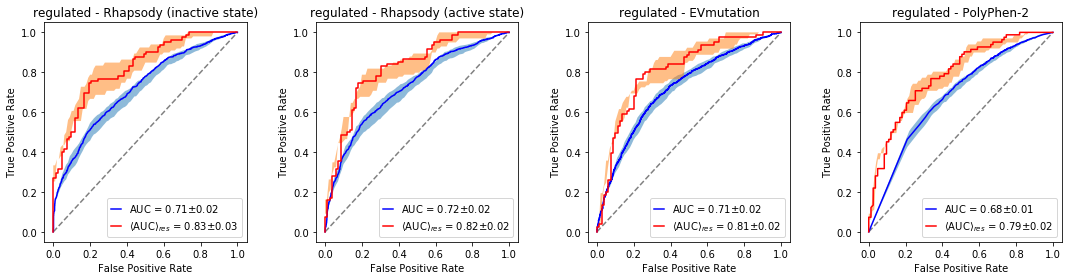

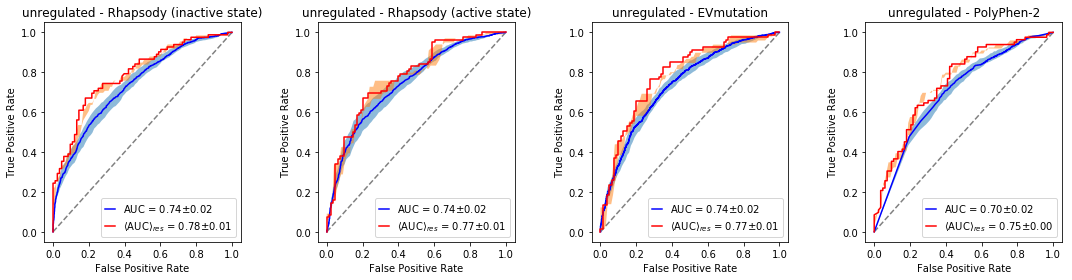

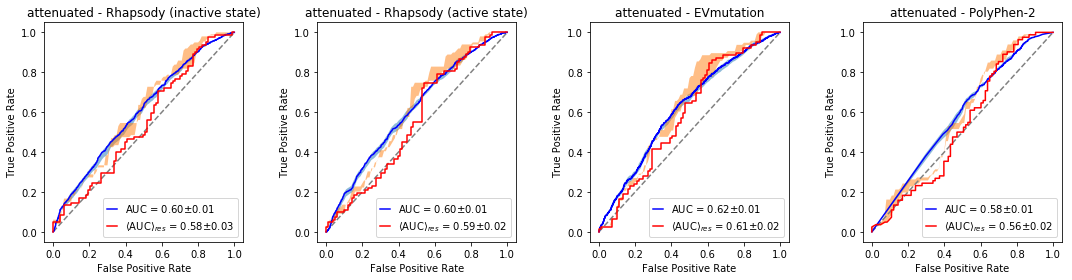

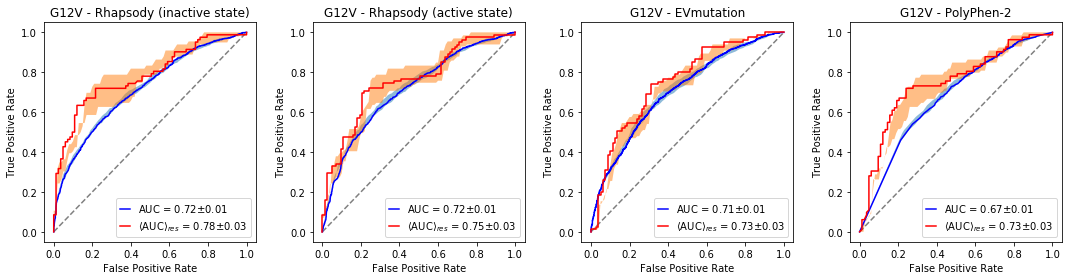

In [37]:
for case in exp_scores:

    fig, axes = plt.subplots(1, 4, figsize=(15,4))
    
    for i, ax in enumerate(axes):
        method = methods[i]
        
        m = metrics_2[case][method]
        q0, q1, q2 = threshold_qs
        
        # random ROC
        ax.plot([0,1], [0,1], '--', color='gray')
        
        # plot for individual fitness effects
        aucs = [m[q]['AUROC'] for q in m.keys()]
        l = r'AUC = {:4.2f}$\pm${:4.2f}'.format(np.mean(aucs), np.std(aucs))
        ax.plot(m[q1]['ROC'][0], m[q1]['ROC'][1], 'b-', label=l)
        x_dense = np.arange(0,1,.01) 
        ax.fill_between(x_dense, np.interp(x_dense, m[q0]['ROC'][0], m[q0]['ROC'][1]), 
                                 np.interp(x_dense, m[q2]['ROC'][0], m[q2]['ROC'][1]), alpha=.5)

        # plot for residue-averaged fitness effects
        aucs = [m[q]['avg_AUROC'] for q in m.keys()]
        l = r'$\langle$AUC$\rangle _{res}$ = ' 
        l += r'{:4.2f}$\pm${:4.2f}'.format(np.mean(aucs), np.std(aucs)) 
        ax.plot(m[q1]['avg_ROC'][0], m[q1]['avg_ROC'][1], 'r-', label=l)
        x_dense = np.arange(0,1,.01) 
        ax.fill_between(x_dense, np.interp(x_dense, m[q0]['avg_ROC'][0], m[q0]['avg_ROC'][1]), 
                                 np.interp(x_dense, m[q2]['avg_ROC'][0], m[q2]['avg_ROC'][1]), alpha=.5)
        
        # set labels
        ax.set_title(f'{case[:-4]} - {method}')   
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(handlelength=1)

    fig.tight_layout()
    fig.savefig(f'figures/ROC-2-{case}.png', dpi=300)

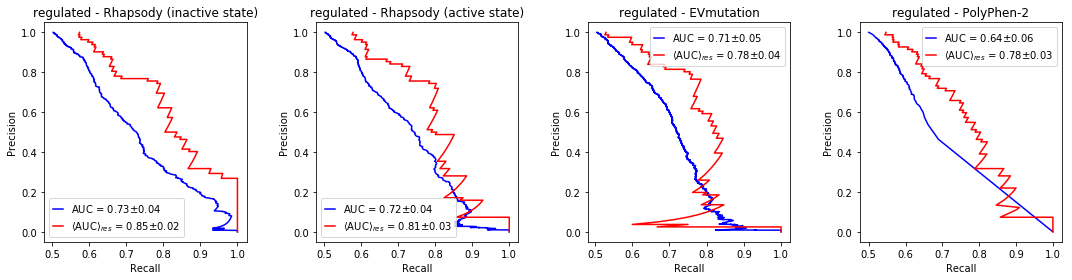

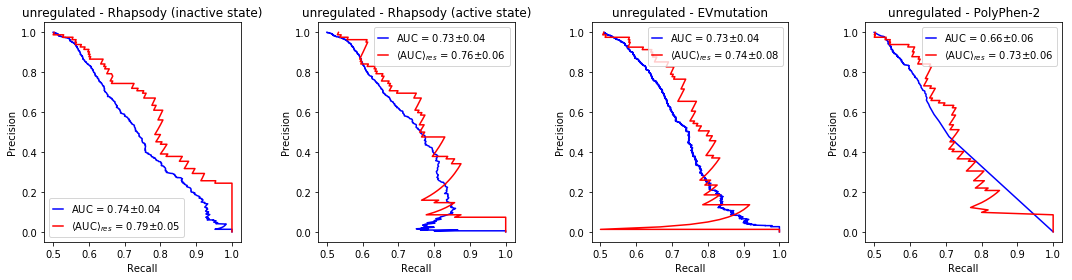

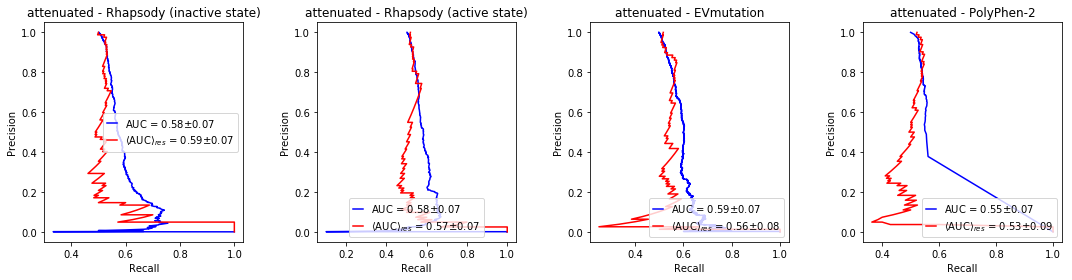

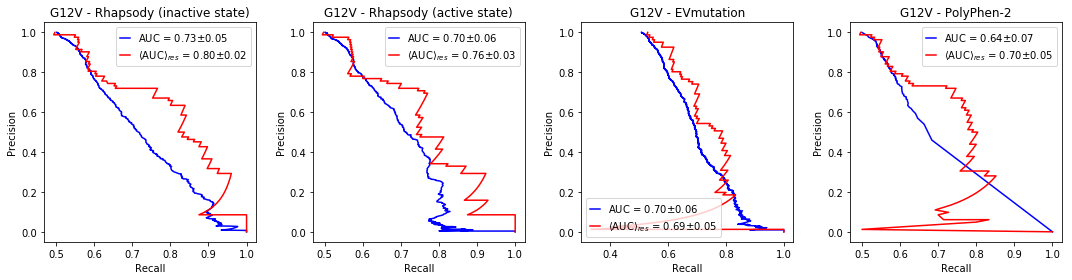

In [38]:
for case in exp_scores:

    fig, axes = plt.subplots(1, 4, figsize=(15,4))
    
    for i, ax in enumerate(axes):
        method = methods[i]
        
        m = metrics_2[case][method]
        q0, q1, q2 = threshold_qs
        
        # plot for individual fitness effects
        aucs = [m[q]['AUPRC'] for q in cutoff_qs]
        l = r'AUC = {:4.2f}$\pm${:4.2f}'.format(np.mean(aucs), np.std(aucs))
        ax.plot(m[q1]['PRC'][0], m[q1]['PRC'][1], 'b-', label=l)

        # plot for residue-averaged fitness effects
        aucs = [m[q]['avg_AUPRC'] for q in cutoff_qs]
        l = r'$\langle$AUC$\rangle _{res}$ = ' 
        l += r'{:4.2f}$\pm${:4.2f}'.format(np.mean(aucs), np.std(aucs)) 
        ax.plot(m[q1]['avg_PRC'][0], m[q1]['avg_PRC'][1], 'r-', label=l)
        
        # set labels
        ax.set_title(f'{case[:-4]} - {method}')   
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(handlelength=1)

    fig.tight_layout()
    fig.savefig(f'figures/PRC-2-{case}.png', dpi=300)

### *In silico* saturation mutagenesis table
Experimental measurements (fitness scores) are reversed to make the comparison with computational profiles easier.

In [39]:
exp_score = - exp_scores['regulated_RAS']

In [40]:
rhaps.print_sat_mutagen_figure('figures/sat_mutagen-inactive-1', rh, extra_plot=exp_score, res_interval=(1,95))
rhaps.print_sat_mutagen_figure('figures/sat_mutagen-inactive-2', rh, extra_plot=exp_score, res_interval=(95,190))

@> Saturation mutagenesis figure saved to figures/sat_mutagen-inactive-1.png
@> Saturation mutagenesis figure saved to figures/sat_mutagen-inactive-2.png


In [41]:
rhaps.print_sat_mutagen_figure('figures/sat_mutagen-active-1', rh_active, extra_plot=exp_score, res_interval=(1,95))
rhaps.print_sat_mutagen_figure('figures/sat_mutagen-active-2', rh_active, extra_plot=exp_score, res_interval=(95,190))

@> Recovering EVmutation data...
@> EVmutation scores recovered in 6.4s.
@> Saturation mutagenesis figure saved to figures/sat_mutagen-active-1.png
@> Saturation mutagenesis figure saved to figures/sat_mutagen-active-2.png


We plot the secondary structure and solvent accessible surface area (SASA) in two strips to be paired with the saturation mutagenesis tables.

In [42]:
# compute secondary structure and SASA with DSSP
ag = prody.performDSSP('6q21')
os.remove('6q21.pdb')
os.remove('6q21.dssp')

@> PDB file is found in the local folder (6q21.pdb).
@> 6057 atoms and 1 coordinate set(s) were parsed in 0.08s.


In [43]:
SASAs = np.zeros(190)
SSTRs = np.zeros(190)
SASAs[:] = np.nan
SSTRs[:] = np.nan

ag_ca = ag['A'].ca
for resid, sasa, sstr in zip(ag_ca.getResnums(), ag_ca.getData('dssp_acc'), ag_ca.getSecstrs()):
    SASAs[resid-1] = sasa
    if sstr in list('GHI'): # helix
        _sstr = 2
    elif sstr in list('EB'): # strand
        _sstr = 1
    else: # loop
        _sstr = np.nan
    SSTRs[resid-1] = _sstr

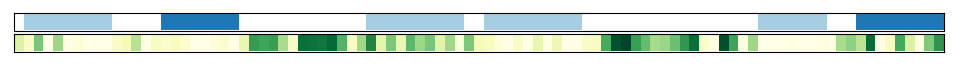

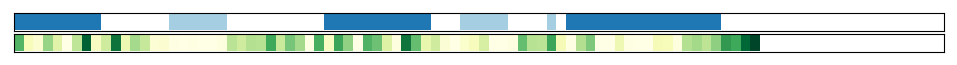

In [44]:
for i, (res_i, res_f) in enumerate([(1,95), (95,190)]):
    
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 0.5))
    for ax in (ax0, ax1):
        ax.tick_params(axis='both', which='both', left=False, bottom=False, labelbottom=False, labelleft=False)
    # plot secondary structure
    SSTR_plot = SSTRs[res_i-1:res_f].reshape((1,-1))
    ax0.imshow(SSTR_plot, aspect='auto', cmap='Paired', vmax=12)
    # plot SASA
    SASA_plot = SASAs[res_i-1:res_f].reshape((1,-1))
    ax1.imshow(SASA_plot, aspect='auto', cmap='YlGn')
    fig.savefig(f'figures/sat_mutagen-active-{i+1}-strip', dip=300)

### Agreement with experimental measurements shown on PDB structure
We highlight on the 3D structure of RAS those residues were Rhapsody generally fails to provide correct predictions, in an attempt to identify the method's limitations.

/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]


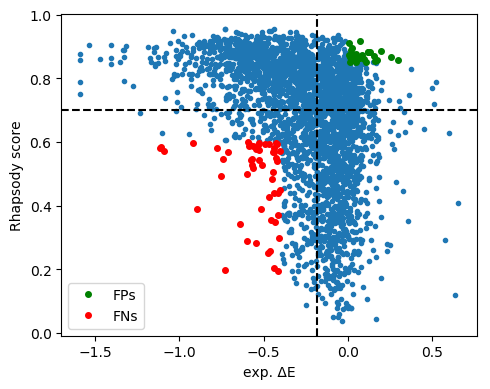

In [45]:
sel = np.logical_and(~np.isnan(exp_scores['regulated_RAS']), ~np.isnan(exp_scores['regulated_RAS']))
exp_score = exp_scores['regulated_RAS']
comput_score = rh_active.predictions['score']

exp_cutoff    = np.nanmedian(exp_score)
comput_cutoff = rh_active.CVsummary['optimal cutoff'][0]

FPs = np.logical_and(exp_score > exp_cutoff, comput_score > comput_cutoff)
FNs = np.logical_and(exp_score < exp_cutoff, comput_score < comput_cutoff)

# We arbitrarily select two subsets with the least accurate predictions
worst_FPs = np.logical_and(exp_score > 0, comput_score > 0.85)
worst_FNs = np.logical_and(exp_score < -.4, comput_score < 0.6)

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(exp_score, comput_score, '.')
ax.plot(exp_score[worst_FPs], comput_score[worst_FPs], 'g.', ms=8, label='FPs')
ax.plot(exp_score[worst_FNs], comput_score[worst_FNs], 'r.', ms=8, label='FNs')

ax.axvline(exp_cutoff, ls='--', c='k')
ax.axhline(comput_cutoff, ls='--', c='k')

ax.set_ylabel('Rhapsody score')
ax.set_xlabel('exp. ΔE')

ax.legend()
fig.tight_layout()
plt.savefig(f'figures/scatter_plot-FPsFNs.png', dpi=300)

In [46]:
worst_FP_resids = set([int(s.split()[2]) for s in rh_active.Uniprot2PDBmap['PDB SAV coords'][worst_FPs]])
worst_FN_resids = set([int(s.split()[2]) for s in rh_active.Uniprot2PDBmap['PDB SAV coords'][worst_FNs]])
# the two sets are mutually exclusive
worst_FP_resids.intersection(worst_FN_resids)

set()

In [47]:
pdb = prody.parsePDB('6q21', chain='A').select('protein and resid 2 to 166')

# replace the B-factor column in chain A with Rhapsody predictions
PDBresids = pdb.getResnums()
new_betas = np.zeros_like(PDBresids, dtype=float)
for i, resid in enumerate(PDBresids):
    if resid in worst_FP_resids:
        beta = 1
    elif resid in worst_FN_resids:
        beta = -1
    else:
        beta = 0
    new_betas[i] = beta
# write modified PDB
pdb.setBetas(new_betas)
f = prody.writePDB(f'figures/mapped_pdb-FPsFNs', pdb)

@> PDB file is found in the local folder (/home/lponzoni/.../6q21.pdb.gz).
@> 1484 atoms and 1 coordinate set(s) were parsed in 0.03s.
